In [87]:
import tensorflow as tf
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential

batch_size = 32
img_height = 180
img_width = 180

In [88]:
data_dir = pathlib.Path('img')
val_dir = pathlib.Path('img')

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode = 'grayscale')

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  val_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode = 'grayscale')

Found 1609 files belonging to 52 classes.
Using 1288 files for training.
Found 1609 files belonging to 52 classes.
Using 321 files for validation.


In [89]:
class_names = train_ds.class_names
print(class_names)
print(len(class_names))

['_a', '_b', '_c', '_d', '_e', '_f', '_g', '_h', '_i', '_j', '_k', '_l', '_m', '_n', '_o', '_p', '_q', '_r', '_s', '_t', '_u', '_v', '_w', '_x', '_y', '_z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
52


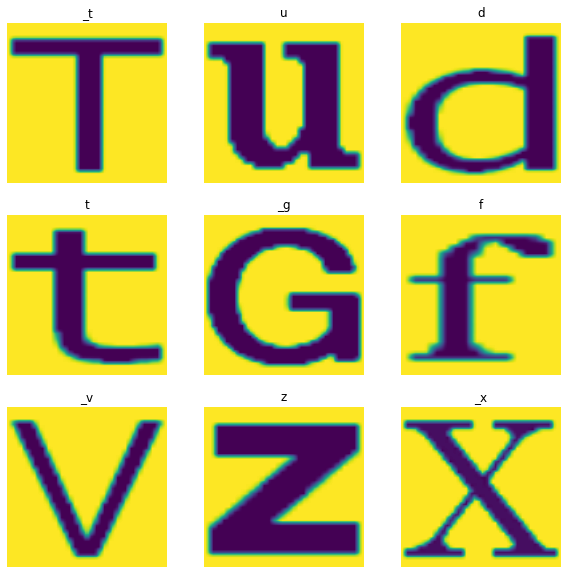

In [90]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [91]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.005226572 0.76670486


In [92]:
num_classes = len(class_names)

model = Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [93]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [94]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
41/41 [==============================] - 16s 386ms/step - loss: 2.6223 - accuracy: 0.3789 - val_loss: 0.9116 - val_accuracy: 0.7414
Epoch 2/20
41/41 [==============================] - 14s 340ms/step - loss: 0.5124 - accuracy: 0.8579 - val_loss: 0.3695 - val_accuracy: 0.8910
Epoch 3/20
41/41 [==============================] - 14s 344ms/step - loss: 0.2183 - accuracy: 0.9425 - val_loss: 0.4666 - val_accuracy: 0.9003
Epoch 4/20
41/41 [==============================] - 14s 343ms/step - loss: 0.1780 - accuracy: 0.9526 - val_loss: 0.1698 - val_accuracy: 0.9408
Epoch 5/20
41/41 [==============================] - 14s 337ms/step - loss: 0.0936 - accuracy: 0.9705 - val_loss: 0.1353 - val_accuracy: 0.9657
Epoch 6/20
41/41 [==============================] - 14s 352ms/step - loss: 0.0618 - accuracy: 0.9806 - val_loss: 0.1053 - val_accuracy: 0.9595
Epoch 7/20
41/41 [==============================] - 14s 343ms/step - loss: 0.0701 - accuracy: 0.9767 - val_loss: 0.0963 - val_accuracy: 0.9502

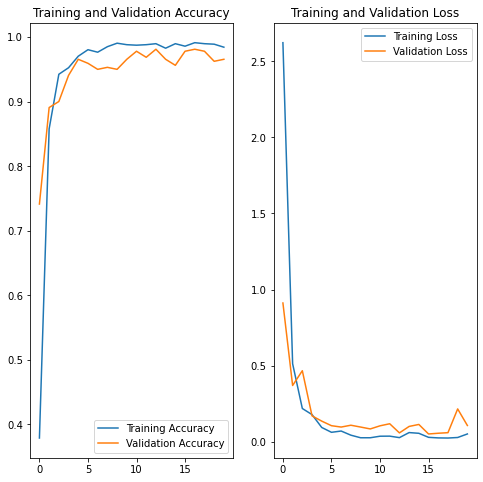

In [95]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [96]:

test_loss, test_acc = model.evaluate(val_ds
    , verbose=2)

print('\n테스트 정확도:', test_acc)

11/11 - 1s - loss: 0.1066 - accuracy: 0.9657

테스트 정확도: 0.9657320976257324


In [97]:
model.save('char_model_v1.h5')

In [98]:
import cv2
from keras.models import load_model

model = load_model('char_model.h5')
src = cv2.imread('test/test3.png',cv2.IMREAD_GRAYSCALE)
test = cv2.imread('img/_a/1.png',cv2.IMREAD_GRAYSCALE)

src_dst = cv2.resize(src, dsize=(180, 180), interpolation=cv2.INTER_AREA)
test_dst = cv2.resize(test, dsize=(180, 180), interpolation=cv2.INTER_AREA)

src_dst = np.array([src_dst])
test_dst = np.array([test_dst])

print(src_dst.shape)
print(test_dst.shape)

src_pd = model.predict(src_dst)
smax_pd = np.argmax(src_pd)

test_pd = model.predict(test_dst)
max_pd = np.argmax(test_pd)

print(smax_pd)
print(max_pd)

print(class_names[smax_pd])
print(class_names[max_pd])

OSError: SavedModel file does not exist at: char_model.h5/{saved_model.pbtxt|saved_model.pb}